# %% [markdown]

 # Sistema de Monitoramento Industrial - Análise de Dados IoT

 **Projeto**: Coleta e análise de dados de sensores ESP32
 **Sensores**: DHT22, MPU6050, LDR
 **Objetivo**: Monitoramento industrial e detecção de anomalias

# %% [markdown]

 ## 📦 Importação de Bibliotecas

In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configurar estilo dos gráficos
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.style.use('default')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


# %% [markdown]

 ## 🔧 Geração de Dados Simulados

 Baseado no comportamento real dos sensores conectados ao ESP32:
 - **DHT22**: Temperatura e umidade com correlação inversa
 - **MPU6050**: Aceleração com gravidade + ruído
 - **LDR**: Luminosidade com padrão cíclico

In [ ]:
# %%

def generate_sensor_data(n_samples=300, interval_seconds=2):
    """
    Gera dados realísticos baseados nos sensores do projeto
    """
    print(f"Gerando {n_samples} amostras com intervalo de {interval_seconds}s...")
    
    # Timestamps em segundos
    timestamps = np.arange(0, n_samples * interval_seconds, interval_seconds)
    
    # DHT22 - Temperatura (°C)
    base_temp = 24.7  # Valor base do sensor
    temp_trend = np.sin(timestamps * 0.01) * 2  # Variação lenta
    temp_daily = np.sin(timestamps * 0.001) * 4  # Ciclo diário simulado
    temp_noise = np.random.normal(0, 0.3, n_samples)
    temperatura = base_temp + temp_trend + temp_daily + temp_noise
    
    # DHT22 - Umidade (%) - correlação inversa com temperatura
    base_humidity = 55
    humidity_from_temp = -(temperatura - base_temp) * 1.2  # Correlação inversa
    humidity_noise = np.random.normal(0, 1.5, n_samples)
    umidade = base_humidity + humidity_from_temp + humidity_noise
    umidade = np.clip(umidade, 30, 85)  # Limites realísticos
    
    # LDR - Luminosidade (%) - padrão cíclico dia/noite
    light_cycle = 50 + 35 * np.sin(timestamps * 0.008)  # Ciclo de 12 horas simulado
    light_weather = np.random.normal(0, 8, n_samples)  # Variação climática
    luminosidade = light_cycle + light_weather
    luminosidade = np.clip(luminosidade, 0, 100)
    
    # MPU6050 - Acelerômetro (mg)
    # Eixo Z: Gravidade (1g = 1000mg) + vibração
    accel_z_base = 1000  # Gravidade
    accel_z_vibration = np.random.normal(0, 25, n_samples)
    accel_z = accel_z_base + accel_z_vibration
    
    # Eixos X e Y: Principalmente ruído com algumas vibrações
    accel_x = np.random.normal(0, 50, n_samples)
    accel_y = np.random.normal(0, 50, n_samples)
    
    # MPU6050 - Giroscópio (°/s convertido para m°/s)
    gyro_x = np.random.normal(0, 30, n_samples)
    gyro_y = np.random.normal(0, 30, n_samples)
    gyro_z = np.random.normal(0, 20, n_samples)
    
    # Inserir algumas anomalias (10% dos dados)
    anomaly_indices = np.random.choice(range(n_samples), size=int(n_samples*0.1), replace=False)
    
    # Anomalias de temperatura
    temperatura[anomaly_indices[:len(anomaly_indices)//3]] += np.random.uniform(8, 15, len(anomaly_indices)//3)
    
    # Anomalias de vibração
    vibration_anomalies = anomaly_indices[len(anomaly_indices)//3:2*len(anomaly_indices)//3]
    accel_x[vibration_anomalies] += np.random.uniform(300, 800, len(vibration_anomalies))
    accel_y[vibration_anomalies] += np.random.uniform(300, 800, len(vibration_anomalies))
    
    # Anomalias de luminosidade
    light_anomalies = anomaly_indices[2*len(anomaly_indices)//3:]
    luminosidade[light_anomalies] = np.random.uniform(0, 15, len(light_anomalies))
    
    # Criar DataFrame
    df = pd.DataFrame({
        'Timestamp': timestamps,
        'Temperatura': temperatura.round(2),
        'Umidade': umidade.round(2),
        'Luminosidade': luminosidade.round(2),
        'Accel_X': accel_x.round(0).astype(int),
        'Accel_Y': accel_y.round(0).astype(int),
        'Accel_Z': accel_z.round(0).astype(int),
        'Gyro_X': gyro_x.round(0).astype(int),
        'Gyro_Y': gyro_y.round(0).astype(int),
        'Gyro_Z': gyro_z.round(0).astype(int)
    })
    
    print(f"✅ Dados gerados: {len(df)} registros")
    return df

# Gerar dados
df_sensors = generate_sensor_data(n_samples=250)

# Mostrar primeiras linhas
print("\n📊 Primeiras 5 amostras:")
print(df_sensors.head())

Gerando 250 amostras com intervalo de 2s...
✅ Dados gerados: 250 registros

📊 Primeiras 5 amostras:
   Timestamp  Temperatura  Umidade  Luminosidade  Accel_X  Accel_Y  Accel_Z  \
0          0        24.19    55.89         59.57       49     -111      997   
1          2        25.13    54.25         34.40       47      -31     1006   
2          4        24.66    56.11         36.16      -19       15     1012   
3          6        25.02    56.22         69.62      -65       43      995   
4          8        24.81    52.46         46.31       10       -5     1005   

   Gyro_X  Gyro_Y  Gyro_Z  
0      79      20     -21  
1      35      50     -18  
2       7      18      -9  
3      -6      39      -9  
4      29     -24      -5  


# %% [markdown]

 ## 📈 Gráfico 1: Temperatura ao Longo do Tempo

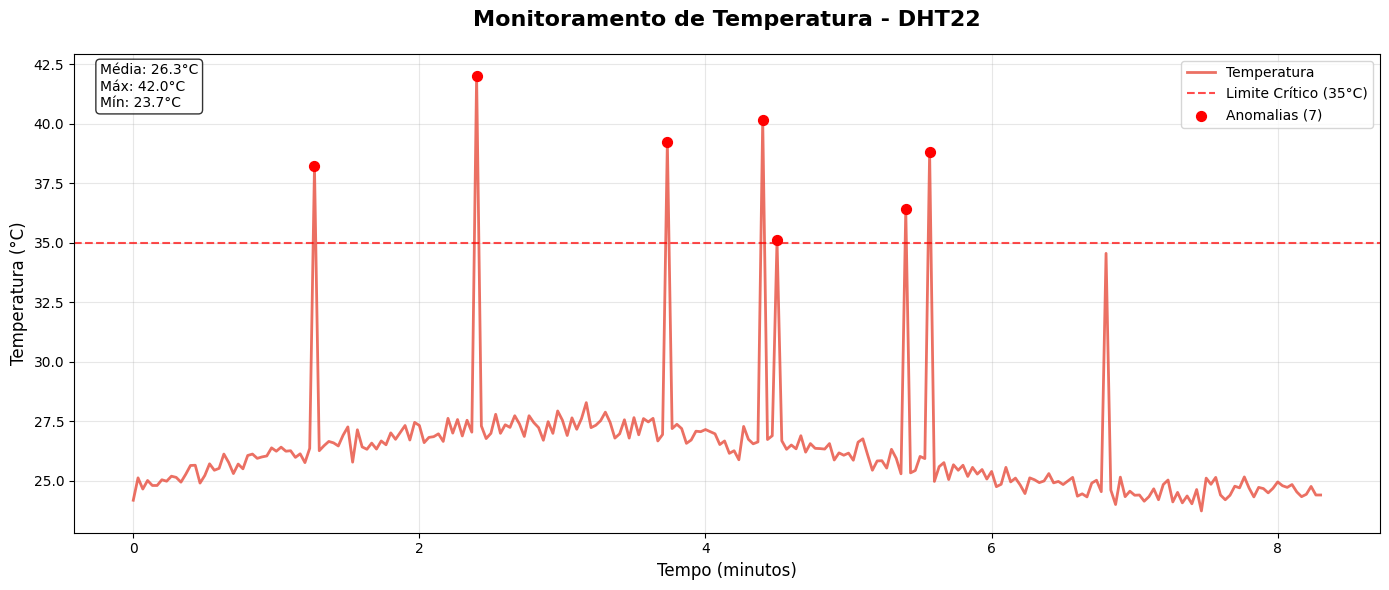

💾 Gráfico salvo como 'temperatura_tempo.png'


In [ ]:
# %%

plt.figure(figsize=(14, 6))

# Plotar temperatura
plt.plot(df_sensors['Timestamp']/60, df_sensors['Temperatura'], 
         linewidth=2, color='#e74c3c', alpha=0.8, label='Temperatura')

# Adicionar linha de alerta
plt.axhline(y=35, color='red', linestyle='--', alpha=0.7, label='Limite Crítico (35°C)')

# Destacar anomalias
temp_anomalies = df_sensors[df_sensors['Temperatura'] > 35]
if not temp_anomalies.empty:
    plt.scatter(temp_anomalies['Timestamp']/60, temp_anomalies['Temperatura'], 
                color='red', s=50, zorder=5, label=f'Anomalias ({len(temp_anomalies)})')

plt.title('Monitoramento de Temperatura - DHT22', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tempo (minutos)', fontsize=12)
plt.ylabel('Temperatura (°C)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(frameon=True, fancybox=True)

# Estatísticas no gráfico
stats_text = f'Média: {df_sensors["Temperatura"].mean():.1f}°C\n'
stats_text += f'Máx: {df_sensors["Temperatura"].max():.1f}°C\n'
stats_text += f'Mín: {df_sensors["Temperatura"].min():.1f}°C'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('graficos/img/temperatura_tempo.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'temperatura_tempo.png'")

# %% [markdown]

 ## 📈 Gráfico 2: Correlação Temperatura vs Umidade

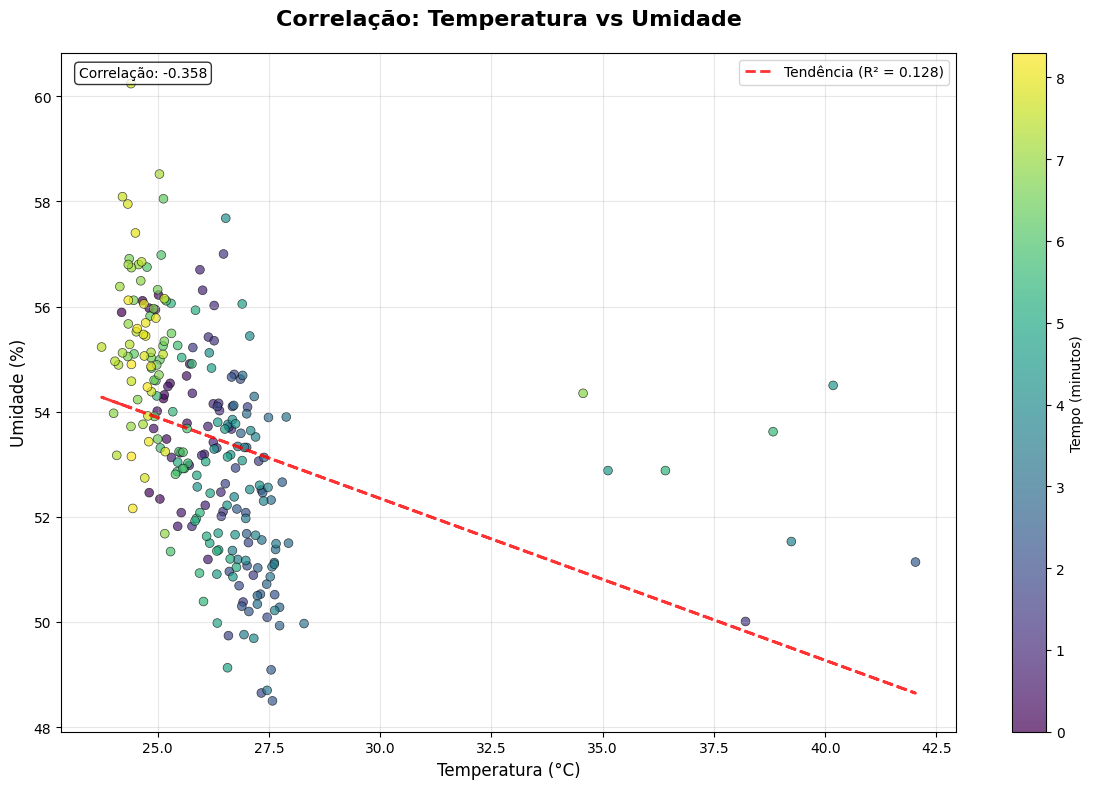

💾 Gráfico salvo como 'correlacao_temp_umidade.png'


In [ ]:
# %%

plt.figure(figsize=(12, 8))

# Scatter plot com colormap baseado no tempo
scatter = plt.scatter(df_sensors['Temperatura'], df_sensors['Umidade'], 
                     c=df_sensors['Timestamp']/60, cmap='viridis', 
                     alpha=0.7, s=40, edgecolors='black', linewidth=0.5)

# Linha de tendência
z = np.polyfit(df_sensors['Temperatura'], df_sensors['Umidade'], 1)
p = np.poly1d(z)
plt.plot(df_sensors['Temperatura'], p(df_sensors['Temperatura']), 
         "--", color='red', linewidth=2, alpha=0.8, label=f'Tendência (R² = {np.corrcoef(df_sensors["Temperatura"], df_sensors["Umidade"])[0,1]**2:.3f})')

plt.colorbar(scatter, label='Tempo (minutos)')
plt.title('Correlação: Temperatura vs Umidade', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Temperatura (°C)', fontsize=12)
plt.ylabel('Umidade (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Adicionar correlação
correlation = df_sensors['Temperatura'].corr(df_sensors['Umidade'])
plt.text(0.02, 0.98, f'Correlação: {correlation:.3f}', 
         transform=plt.gca().transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('graficos/img/correlacao_temp_umidade.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'correlacao_temp_umidade.png'")

# %% [markdown]

 ## 📈 Gráfico 3: Luminosidade e Padrão Cíclico

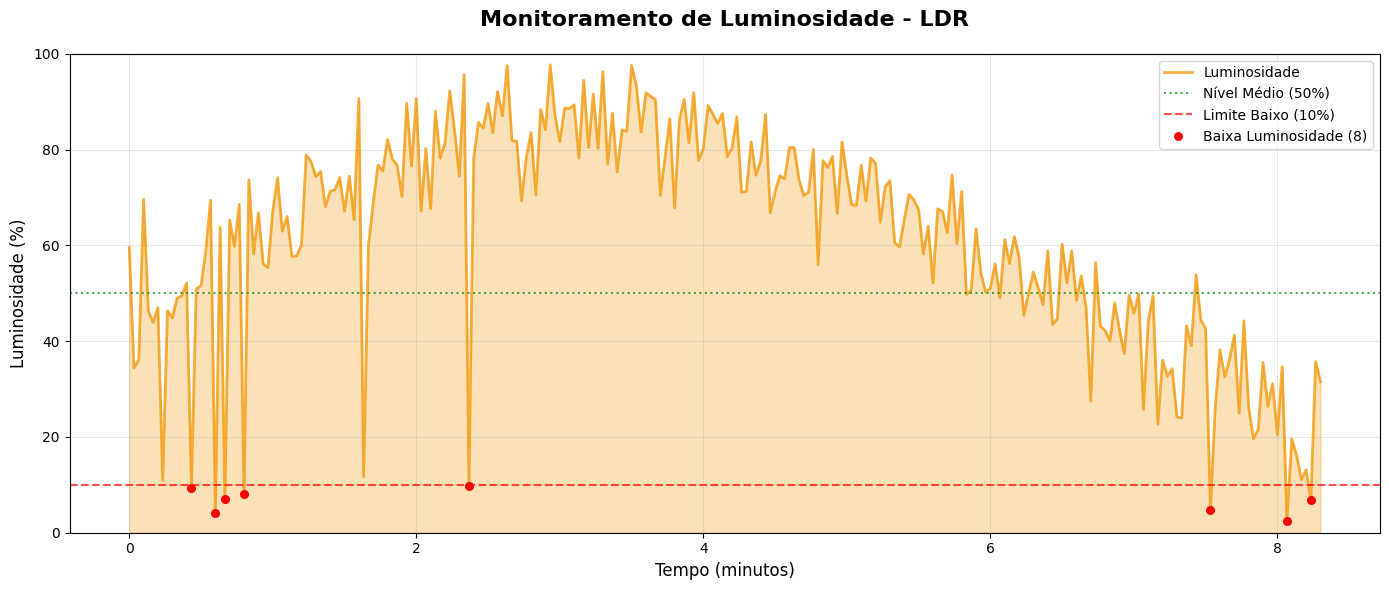

💾 Gráfico salvo como 'luminosidade_tempo.png'


In [ ]:
# %%

plt.figure(figsize=(14, 6))

# Plot principal
plt.plot(df_sensors['Timestamp']/60, df_sensors['Luminosidade'], 
         linewidth=2, color='#f39c12', alpha=0.8, label='Luminosidade')

# Preenchimento da área
plt.fill_between(df_sensors['Timestamp']/60, df_sensors['Luminosidade'], 
                alpha=0.3, color='#f39c12')

# Linhas de referência
plt.axhline(y=50, color='green', linestyle=':', alpha=0.7, label='Nível Médio (50%)')
plt.axhline(y=10, color='red', linestyle='--', alpha=0.7, label='Limite Baixo (10%)')

# Destacar períodos de baixa luminosidade
low_light = df_sensors[df_sensors['Luminosidade'] < 10]
if not low_light.empty:
    plt.scatter(low_light['Timestamp']/60, low_light['Luminosidade'], 
                color='red', s=30, zorder=5, label=f'Baixa Luminosidade ({len(low_light)})')

plt.title('Monitoramento de Luminosidade - LDR', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Tempo (minutos)', fontsize=12)
plt.ylabel('Luminosidade (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('graficos/img/luminosidade_tempo.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'luminosidade_tempo.png'")

# %% [markdown]

 ## 📈 Gráfico 4: Análise de Vibração (MPU6050)

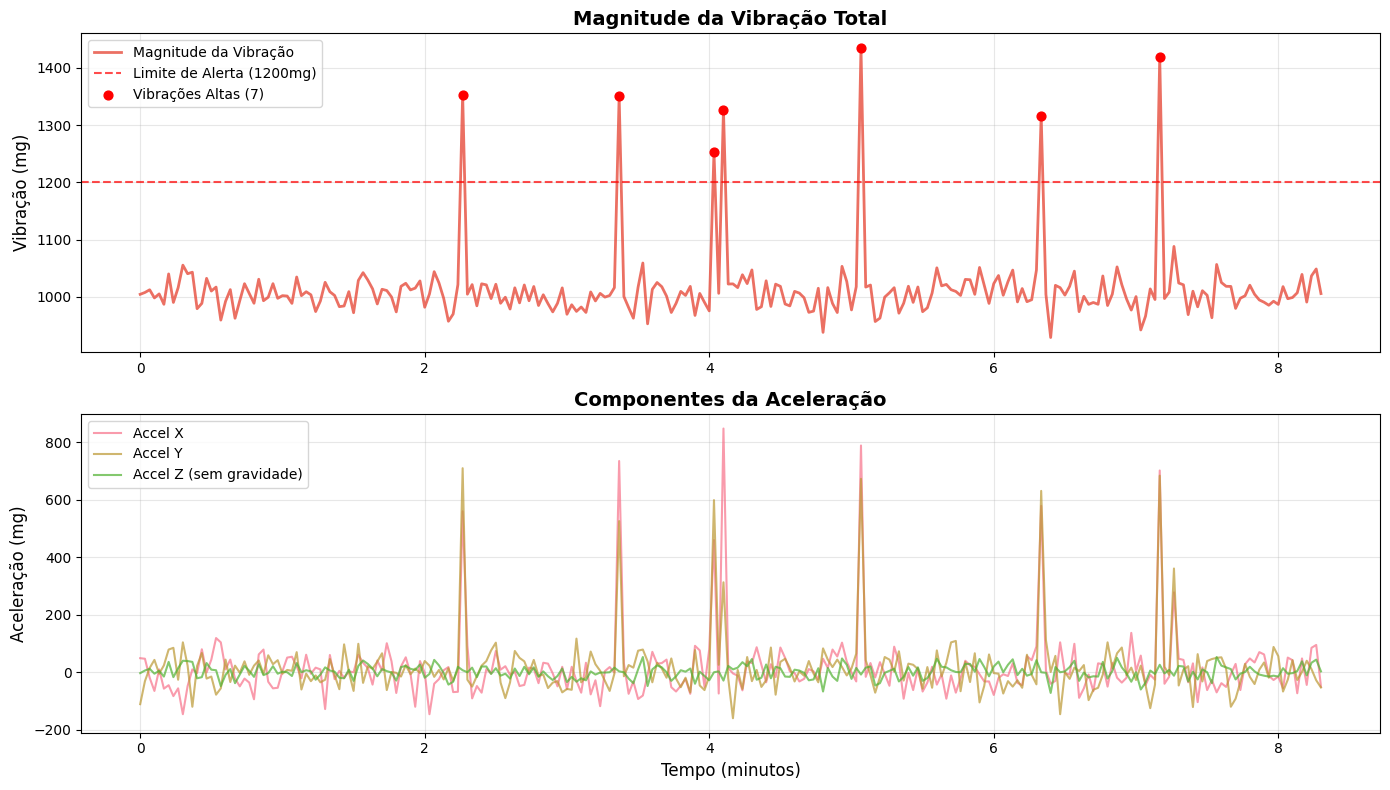

💾 Gráfico salvo como 'vibracao_mpu6050.png'


In [ ]:
# %%

# Calcular magnitude da vibração
vibration_magnitude = np.sqrt(df_sensors['Accel_X']**2 + 
                             df_sensors['Accel_Y']**2 + 
                             df_sensors['Accel_Z']**2)

plt.figure(figsize=(14, 8))

# Subplot para magnitude
plt.subplot(2, 1, 1)
plt.plot(df_sensors['Timestamp']/60, vibration_magnitude, 
         linewidth=2, color='#e74c3c', alpha=0.8, label='Magnitude da Vibração')

# Linha de alerta
plt.axhline(y=1200, color='red', linestyle='--', alpha=0.7, label='Limite de Alerta (1200mg)')

# Anomalias de vibração
high_vibration = df_sensors[vibration_magnitude > 1200]
if not high_vibration.empty:
    plt.scatter(high_vibration['Timestamp']/60, 
                vibration_magnitude[vibration_magnitude > 1200], 
                color='red', s=40, zorder=5, label=f'Vibrações Altas ({len(high_vibration)})')

plt.title('Magnitude da Vibração Total', fontsize=14, fontweight='bold')
plt.ylabel('Vibração (mg)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

# Subplot para componentes individuais
plt.subplot(2, 1, 2)
plt.plot(df_sensors['Timestamp']/60, df_sensors['Accel_X'], 
         alpha=0.7, label='Accel X', linewidth=1.5)
plt.plot(df_sensors['Timestamp']/60, df_sensors['Accel_Y'], 
         alpha=0.7, label='Accel Y', linewidth=1.5)
plt.plot(df_sensors['Timestamp']/60, df_sensors['Accel_Z']-1000, 
         alpha=0.7, label='Accel Z (sem gravidade)', linewidth=1.5)

plt.title('Componentes da Aceleração', fontsize=14, fontweight='bold')
plt.xlabel('Tempo (minutos)', fontsize=12)
plt.ylabel('Aceleração (mg)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.savefig('graficos/img/vibracao_mpu6050.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'vibracao_mpu6050.png'")

# %% [markdown]

 ## 📈 Gráfico 5: Distribuições dos Sensores

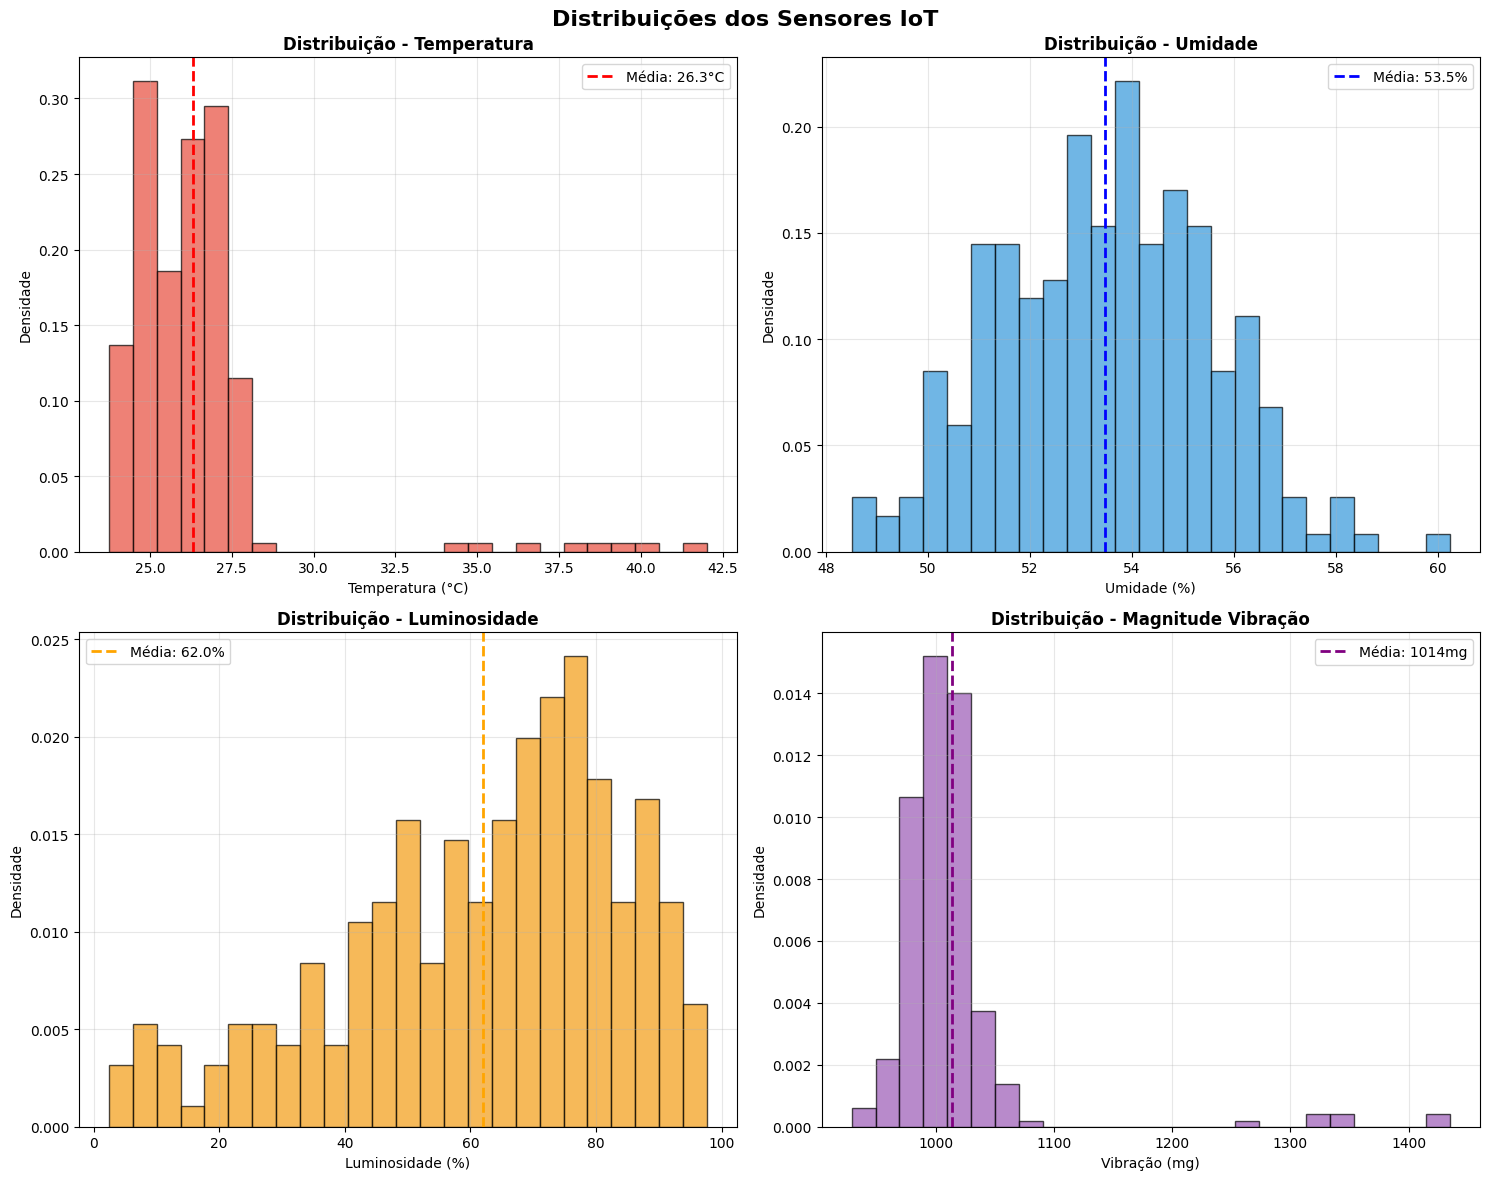

💾 Gráfico salvo como 'distribuicoes_sensores.png'


In [ ]:
# %%

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribuição da Temperatura
axes[0,0].hist(df_sensors['Temperatura'], bins=25, alpha=0.7, color='#e74c3c', 
               edgecolor='black', density=True)
axes[0,0].axvline(df_sensors['Temperatura'].mean(), color='red', linestyle='--', 
                  linewidth=2, label=f'Média: {df_sensors["Temperatura"].mean():.1f}°C')
axes[0,0].set_title('Distribuição - Temperatura', fontweight='bold')
axes[0,0].set_xlabel('Temperatura (°C)')
axes[0,0].set_ylabel('Densidade')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Distribuição da Umidade
axes[0,1].hist(df_sensors['Umidade'], bins=25, alpha=0.7, color='#3498db', 
               edgecolor='black', density=True)
axes[0,1].axvline(df_sensors['Umidade'].mean(), color='blue', linestyle='--', 
                  linewidth=2, label=f'Média: {df_sensors["Umidade"].mean():.1f}%')
axes[0,1].set_title('Distribuição - Umidade', fontweight='bold')
axes[0,1].set_xlabel('Umidade (%)')
axes[0,1].set_ylabel('Densidade')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Distribuição da Luminosidade
axes[1,0].hist(df_sensors['Luminosidade'], bins=25, alpha=0.7, color='#f39c12', 
               edgecolor='black', density=True)
axes[1,0].axvline(df_sensors['Luminosidade'].mean(), color='orange', linestyle='--', 
                  linewidth=2, label=f'Média: {df_sensors["Luminosidade"].mean():.1f}%')
axes[1,0].set_title('Distribuição - Luminosidade', fontweight='bold')
axes[1,0].set_xlabel('Luminosidade (%)')
axes[1,0].set_ylabel('Densidade')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Distribuição da Vibração
axes[1,1].hist(vibration_magnitude, bins=25, alpha=0.7, color='#9b59b6', 
               edgecolor='black', density=True)
axes[1,1].axvline(vibration_magnitude.mean(), color='purple', linestyle='--', 
                  linewidth=2, label=f'Média: {vibration_magnitude.mean():.0f}mg')
axes[1,1].set_title('Distribuição - Magnitude Vibração', fontweight='bold')
axes[1,1].set_xlabel('Vibração (mg)')
axes[1,1].set_ylabel('Densidade')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.suptitle('Distribuições dos Sensores IoT', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('graficos/img/distribuicoes_sensores.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'distribuicoes_sensores.png'")

# %% [markdown]

 ## 📈 Gráfico 6: Matriz de Correlação

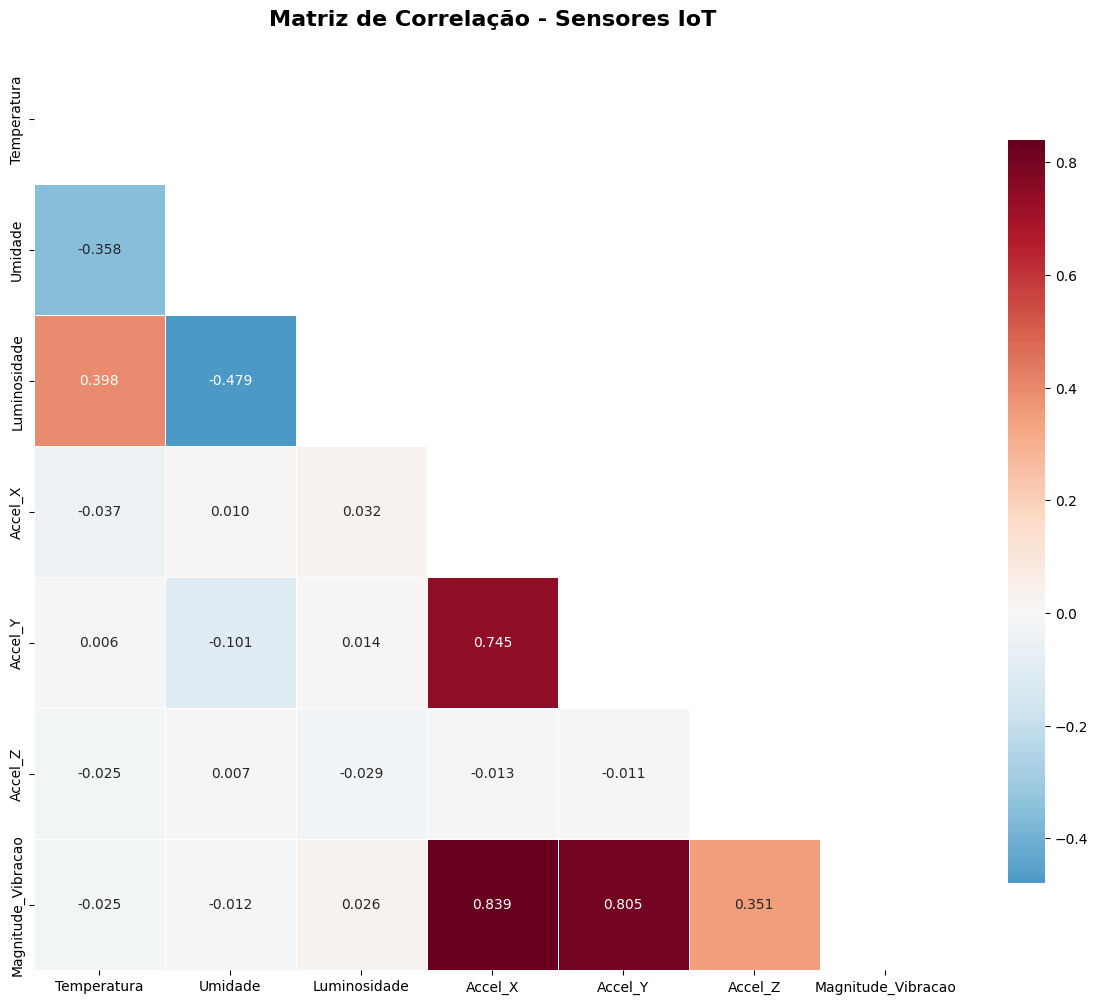

💾 Gráfico salvo como 'matriz_correlacao.png'


In [ ]:
# %%

plt.figure(figsize=(12, 10))

# Adicionar magnitude da vibração ao DataFrame para correlação
df_corr = df_sensors.copy()
df_corr['Magnitude_Vibracao'] = vibration_magnitude

# Selecionar apenas colunas numéricas principais
correlation_columns = ['Temperatura', 'Umidade', 'Luminosidade', 
                      'Accel_X', 'Accel_Y', 'Accel_Z', 'Magnitude_Vibracao']
correlation_matrix = df_corr[correlation_columns].corr()

# Criar heatmap
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={"shrink": .8},
            mask=mask, linewidths=0.5)

plt.title('Matriz de Correlação - Sensores IoT', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('graficos/img/matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Gráfico salvo como 'matriz_correlacao.png'")

# %% [markdown]

 ## 📈 Gráfico 7: Dashboard Completo

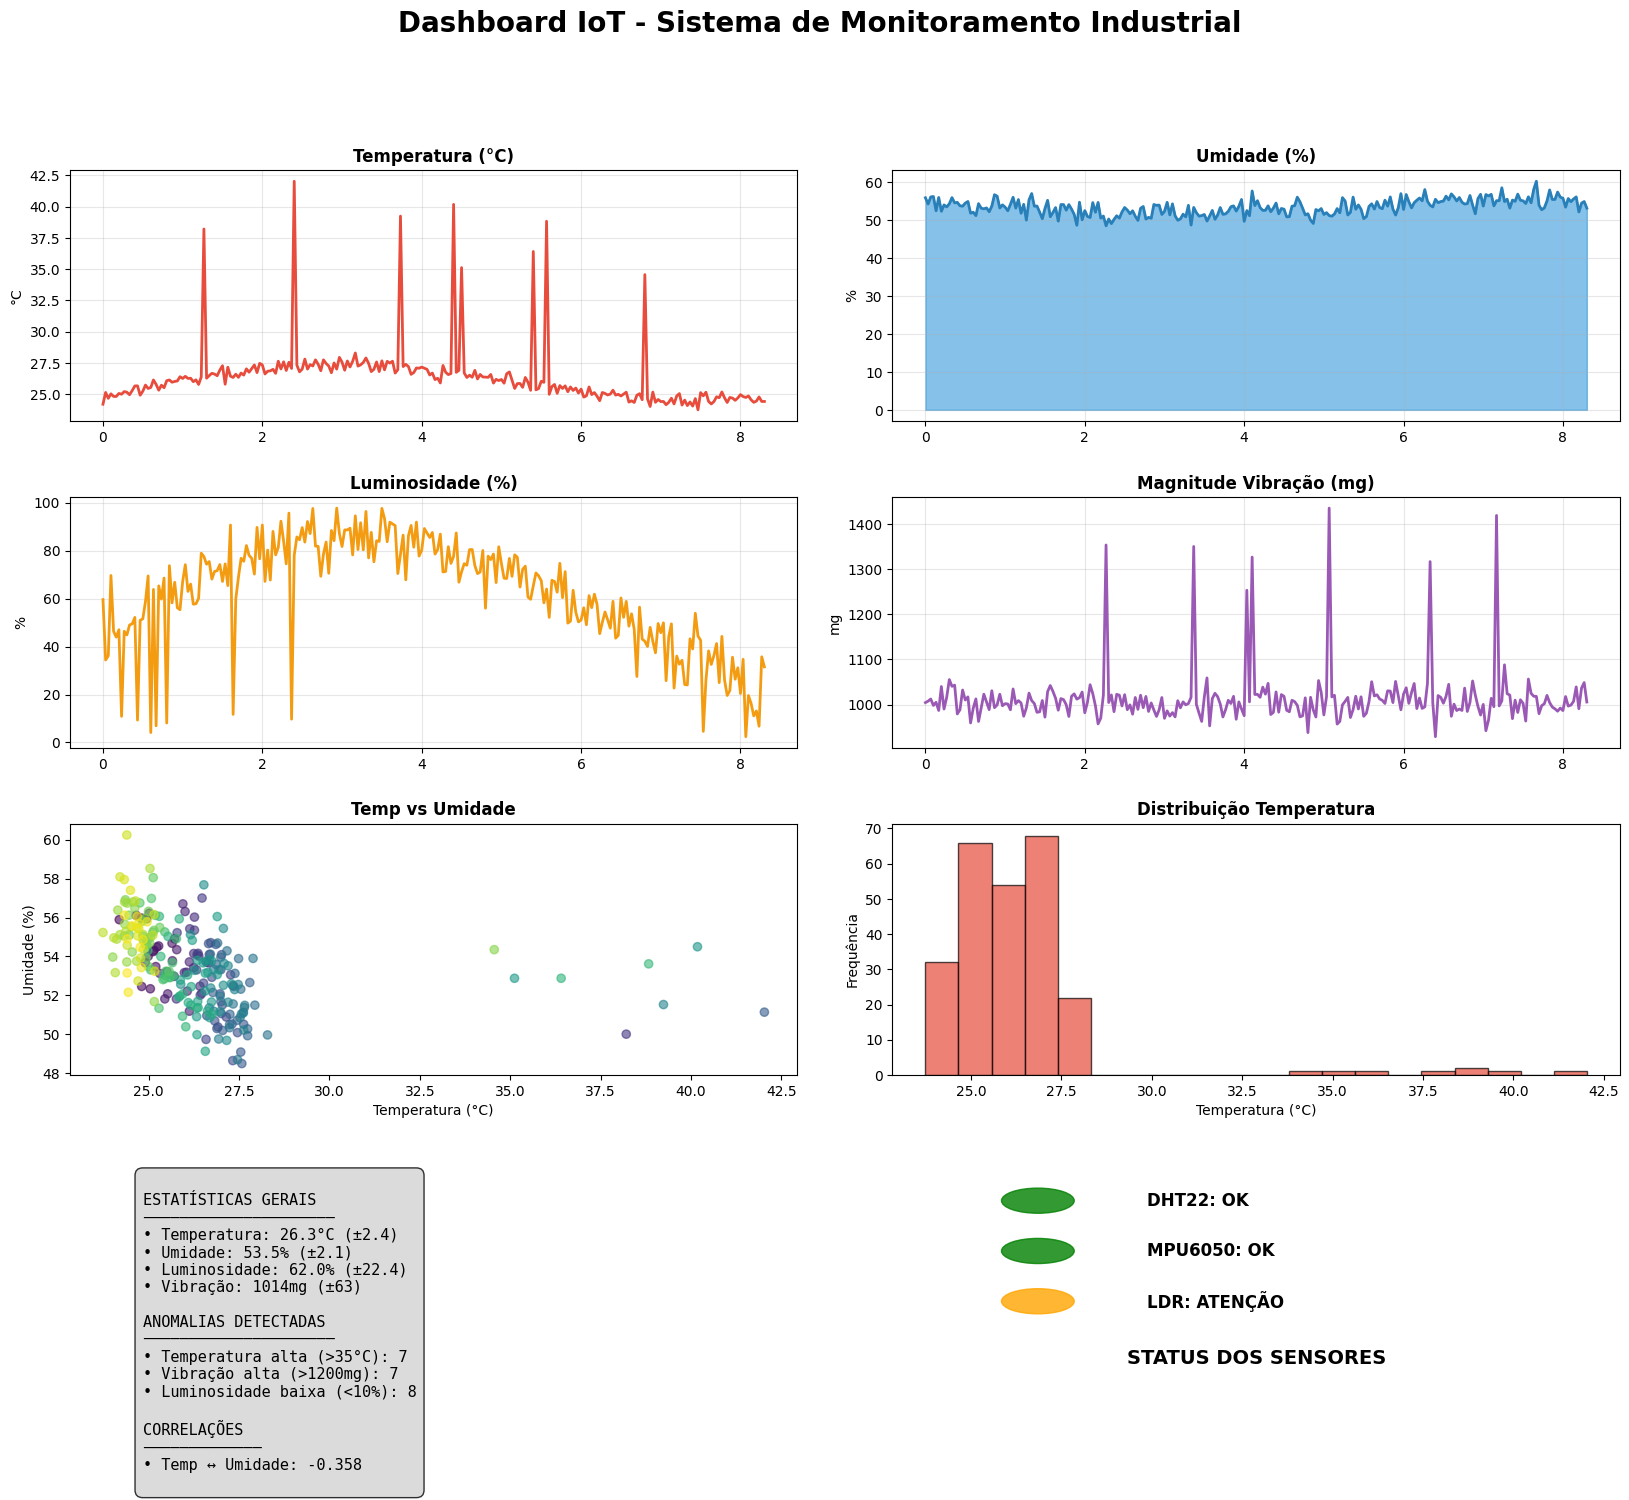

💾 Dashboard salvo como 'dashboard_completo.png'


In [ ]:
# %%

fig = plt.figure(figsize=(20, 16))

# Layout do dashboard
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)

# 1. Temperatura (linha)
ax1 = fig.add_subplot(gs[0, :2])
ax1.plot(df_sensors['Timestamp']/60, df_sensors['Temperatura'], 
         color='#e74c3c', linewidth=2)
ax1.set_title('Temperatura (°C)', fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_ylabel('°C')

# 2. Umidade (área)
ax2 = fig.add_subplot(gs[0, 2:])
ax2.fill_between(df_sensors['Timestamp']/60, df_sensors['Umidade'], 
                alpha=0.6, color='#3498db')
ax2.plot(df_sensors['Timestamp']/60, df_sensors['Umidade'], 
         color='#2980b9', linewidth=2)
ax2.set_title('Umidade (%)', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylabel('%')

# 3. Luminosidade (linha)
ax3 = fig.add_subplot(gs[1, :2])
ax3.plot(df_sensors['Timestamp']/60, df_sensors['Luminosidade'], 
         color='#f39c12', linewidth=2)
ax3.set_title('Luminosidade (%)', fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylabel('%')

# 4. Vibração (linha)
ax4 = fig.add_subplot(gs[1, 2:])
ax4.plot(df_sensors['Timestamp']/60, vibration_magnitude, 
         color='#9b59b6', linewidth=2)
ax4.set_title('Magnitude Vibração (mg)', fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.set_ylabel('mg')

# 5. Scatter Temp vs Umidade
ax5 = fig.add_subplot(gs[2, :2])
scatter = ax5.scatter(df_sensors['Temperatura'], df_sensors['Umidade'], 
                     c=df_sensors['Timestamp']/60, cmap='viridis', alpha=0.6)
ax5.set_title('Temp vs Umidade', fontweight='bold')
ax5.set_xlabel('Temperatura (°C)')
ax5.set_ylabel('Umidade (%)')

# 6. Histograma Temperatura
ax6 = fig.add_subplot(gs[2, 2:])
ax6.hist(df_sensors['Temperatura'], bins=20, alpha=0.7, color='#e74c3c', edgecolor='black')
ax6.set_title('Distribuição Temperatura', fontweight='bold')
ax6.set_xlabel('Temperatura (°C)')
ax6.set_ylabel('Frequência')

# 7. Estatísticas (texto)
ax7 = fig.add_subplot(gs[3, :2])
ax7.axis('off')

stats_text = f"""
ESTATÍSTICAS GERAIS
─────────────────────
• Temperatura: {df_sensors['Temperatura'].mean():.1f}°C (±{df_sensors['Temperatura'].std():.1f})
• Umidade: {df_sensors['Umidade'].mean():.1f}% (±{df_sensors['Umidade'].std():.1f})
• Luminosidade: {df_sensors['Luminosidade'].mean():.1f}% (±{df_sensors['Luminosidade'].std():.1f})
• Vibração: {vibration_magnitude.mean():.0f}mg (±{vibration_magnitude.std():.0f})

ANOMALIAS DETECTADAS
─────────────────────
• Temperatura alta (>35°C): {len(df_sensors[df_sensors['Temperatura'] > 35])}
• Vibração alta (>1200mg): {len(df_sensors[vibration_magnitude > 1200])}
• Luminosidade baixa (<10%): {len(df_sensors[df_sensors['Luminosidade'] < 10])}

CORRELAÇÕES
─────────────
• Temp ↔ Umidade: {df_sensors['Temperatura'].corr(df_sensors['Umidade']):.3f}
"""

ax7.text(0.1, 0.9, stats_text, transform=ax7.transAxes, fontsize=11,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.8))

# 8. Status dos sensores
ax8 = fig.add_subplot(gs[3, 2:])
ax8.axis('off')

# Status visual
sensors_status = ['DHT22', 'MPU6050', 'LDR']
status_colors = ['green', 'green', 'orange']  # Simular status
y_positions = [0.8, 0.6, 0.4]

for i, (sensor, color, y_pos) in enumerate(zip(sensors_status, status_colors, y_positions)):
    ax8.add_patch(plt.Circle((0.2, y_pos), 0.05, color=color, alpha=0.8))
    ax8.text(0.35, y_pos, f'{sensor}: {"OK" if color == "green" else "ATENÇÃO"}', 
             fontsize=12, verticalalignment='center', fontweight='bold')

ax8.set_xlim(0, 1)
ax8.set_ylim(0, 1)
ax8.text(0.5, 0.15, 'STATUS DOS SENSORES', ha='center', fontsize=14, fontweight='bold')

plt.suptitle('Dashboard IoT - Sistema de Monitoramento Industrial', 
             fontsize=20, fontweight='bold', y=0.98)

plt.savefig('graficos/img/dashboard_completo.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Dashboard salvo como 'dashboard_completo.png'")

# %% [markdown]

 ## 💾 Exportação dos Dados

In [ ]:
# %%

# Adicionar magnitude da vibração ao DataFrame final
df_sensors['Magnitude_Vibracao'] = vibration_magnitude

# Salvar CSV
df_sensors.to_csv('dados_sensores_iot.csv', index=False)
print("💾 Dados exportados para 'dados_sensores_iot.csv'")

# Mostrar resumo final
print("\n" + "="*60)
print("RESUMO DA ANÁLISE - SISTEMA IoT INDUSTRIAL")
print("="*60)
print(f"📊 Total de amostras: {len(df_sensors)}")
print(f"⏱️  Período de coleta: {df_sensors['Timestamp'].max()/60:.1f} minutos")
print(f"🌡️  Temperatura média: {df_sensors['Temperatura'].mean():.2f}°C")
print(f"💧 Umidade média: {df_sensors['Umidade'].mean():.2f}%")
print(f"💡 Luminosidade média: {df_sensors['Luminosidade'].mean():.2f}%")
print(f"📳 Vibração média: {vibration_magnitude.mean():.0f}mg")

print(f"\n⚠️  ALERTAS:")
print(f"   • {len(df_sensors[df_sensors['Temperatura'] > 35])} registros com temperatura alta")
print(f"   • {len(df_sensors[vibration_magnitude > 1200])} registros com vibração alta")
print(f"   • {len(df_sensors[df_sensors['Luminosidade'] < 10])} registros com luminosidade baixa")

print(f"\n📁 ARQUIVOS GERADOS:")
arquivos = ['temperatura_tempo.png', 'correlacao_temp_umidade.png', 'luminosidade_tempo.png',
           'vibracao_mpu6050.png', 'distribuicoes_sensores.png', 'matriz_correlacao.png',
           'dashboard_completo.png', 'dados_sensores_iot.csv']

for arquivo in arquivos:
    print(f"   ✅ {arquivo}")

print("\n🎯 Análise concluída com sucesso!")

💾 Dados exportados para 'dados_sensores_iot.csv'

RESUMO DA ANÁLISE - SISTEMA IoT INDUSTRIAL
📊 Total de amostras: 250
⏱️  Período de coleta: 8.3 minutos
🌡️  Temperatura média: 26.33°C
💧 Umidade média: 53.48%
💡 Luminosidade média: 61.97%
📳 Vibração média: 1014mg

⚠️  ALERTAS:
   • 7 registros com temperatura alta
   • 7 registros com vibração alta
   • 8 registros com luminosidade baixa

📁 ARQUIVOS GERADOS:
   ✅ temperatura_tempo.png
   ✅ correlacao_temp_umidade.png
   ✅ luminosidade_tempo.png
   ✅ vibracao_mpu6050.png
   ✅ distribuicoes_sensores.png
   ✅ matriz_correlacao.png
   ✅ dashboard_completo.png
   ✅ dados_sensores_iot.csv

🎯 Análise concluída com sucesso!
